# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                                                                          
Sample_180  A0A0U1RR32;A0A0U1RRH7;P04908;P0C0S8;P20671;Q7L7L0;Q93077;Q96KK5;Q99878;Q9BTM1                                              14.538
Sample_116  O60814;P06899;P23527;P33778;P57053;P58876;P62807;Q16778;Q5QNW6;Q5QNW6-2;Q8N257;Q93079;Q96A08;Q99877;Q99879;Q99880;U3KQK0   18.182
Sample_153  H3BLU2                                                                                                                     20.561
Sample_030  E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3                                                                                     13.021
Sample_175  P19021;P19021-5;P19021-6                                                                                                   20.134
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                                                           
Sample_168  P18206;P18206-2                                                             14.464
Sample_149  P06702                                                                      13.841
Sample_100  H0Y6Q1;O75354;O75354-2;O75354-3;Q5QPI7;Q5QPI9;Q5QPJ3;Q5QPJ4;Q5QPJ6;Q5QPJ7   13.735
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.684
            A0A075B6Q5                 13.040
            A0A075B6R2                 12.482
            A0A075B6S5                 12.536
            A0A087WSY4                 12.078
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.796
            Q9UI40;Q9UI40-2            13.820
            Q9UIW2                     10.484
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.571
            Q9UP79                     13.151
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.090,15.050,16.842,19.863,16.110,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.655,19.067,...,15.528,15.576,14.124,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.027,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.544,17.705,17.039,16.188,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.826,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.373,15.345,17.084,18.708,14.249,19.433,11.647,11.302
Sample_207,15.739,16.877,15.469,16.898,14.815,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.930,11.898,12.334,12.887,11.887,12.733,12.560,12.930,13.924,13.350
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.371,19.067,16.127,...,11.578,12.228,13.470,14.401,13.312,12.530,12.124,12.106,12.733,12.246
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,14.467,12.543,12.738,14.040,11.528,11.201,14.162,13.234,12.622,12.684
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.385,12.239,12.145,13.077,13.776,11.784,12.776,12.421,12.305,12.870
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.984,13.902,12.841,13.159,11.698,11.577,13.316,13.288,12.290,12.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.804,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 156.56it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.22it/s]

100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.14it/s]

100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.63it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.40it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.80it/s]

100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

100%|██████████| 5/5 [00:01<00:00,  2.86it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.33it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.97it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.15it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.25it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

100%|██████████| 6/6 [00:01<00:00,  4.36it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.31it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.56it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.04it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.02it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.87it/s]

100%|██████████| 7/7 [00:01<00:00,  3.49it/s]

100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.31it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.57it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.91it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.72it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.30it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.32it/s]

100%|██████████| 8/8 [00:01<00:00,  4.33it/s]

100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.29it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.62it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.89it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.39it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.25it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.01it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.05it/s]

100%|██████████| 9/9 [00:02<00:00,  3.93it/s]

100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.68it/s]

 30%|███       | 3/10 [00:00<00:01,  4.78it/s]

 40%|████      | 4/10 [00:00<00:01,  4.41it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.33it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.29it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.21it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.20it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.23it/s]

100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.54it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.75it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.50it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.21it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.20it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.95it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.90it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.97it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.91it/s]

100%|██████████| 11/11 [00:02<00:00,  3.88it/s]

100%|██████████| 11/11 [00:02<00:00,  4.11it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.78it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.93it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.03it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.74it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.68it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.49it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.76it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.93it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.05it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.03it/s]

100%|██████████| 12/12 [00:03<00:00,  3.90it/s]

100%|██████████| 12/12 [00:03<00:00,  3.99it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.89it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.81it/s]

 31%|███       | 4/13 [00:00<00:02,  4.05it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.91it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.64it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.56it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.39it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.39it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.57it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.73it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.73it/s]

100%|██████████| 13/13 [00:03<00:00,  3.69it/s]

100%|██████████| 13/13 [00:03<00:00,  3.79it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.83it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.83it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.27it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.35it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.24it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.07it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.44it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.58it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.60it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.58it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.60it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.65it/s]

100%|██████████| 14/14 [00:03<00:00,  3.80it/s]

100%|██████████| 14/14 [00:03<00:00,  3.65it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.69it/s]

 20%|██        | 3/15 [00:00<00:02,  5.88it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.91it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.64it/s]

 40%|████      | 6/15 [00:01<00:02,  4.36it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.88it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.74it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.70it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.72it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.80it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.83it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.40it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.19it/s]

100%|██████████| 15/15 [00:04<00:00,  2.97it/s]

100%|██████████| 15/15 [00:04<00:00,  3.73it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.045 0.013          0.738 0.368       0.117   
2             0.004 0.001      0.045 0.013          0.694 0.124       0.531   
3             0.006 0.003      0.064 0.028          0.686 0.107       0.618   
4             0.005 0.002      0.047 0.019          0.702 0.110       0.630   
5             0.005 0.003      0.057 0.022          0.701 0.096       0.677   
6             0.007 0.003      0.070 0.027          0.812 0.085       0.804   
7             0.006 0.003      0.055 0.022          0.810 0.087       0.807   
8             0.006 0.003      0.054 0.019          0.807 0.087       0.801   
9             0.006 0.003      0.055 0.024          0.804 0.085       0.804   
10            0.005 0.002      0.051 0.018          0.800 0.087       0.800   
11            0.005 0.002      0.052 0.020          0.824 0.086       0.810   
12            0.006 0.003      0.052 0.019          0.824 0.085       0.824   
13            0.004 0.001      0.043 0.012          0.825 0.085       0.825   
14            0.004 0.001      0.042 0.011          0.823 0.083       0.804   
15            0.004 0.001      0.042 0.013          0.821 0.079       0.801   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.194 0.132                  0.551 0.042        0.845   
2          0.107   0.593 0.088                  0.675 0.063        0.722   
3          0.131   0.641 0.093                  0.701 0.073        0.778   
4          0.109   0.656 0.081                  0.713 0.064        0.801   
5          0.113   0.683 0.078                  0.730 0.065        0.808   
6          0.110   0.803 0.075                  0.832 0.062        0.897   
7          0.107   0.803 0.072                  0.832 0.061        0.896   
8          0.108   0.799 0.073                  0.829 0.061        0.893   
9          0.104   0.799 0.070                  0.828 0.059        0.892   
10         0.106   0.795 0.074                  0.825 0.063        0.895   
11         0.110   0.812 0.073                  0.840 0.062        0.904   
12         0.105   0.820 0.073                  0.846 0.062        0.904   
13         0.107   0.820 0.075                  0.847 0.064        0.903   
14         0.104   0.809 0.070                  0.837 0.058        0.908   
15         0.094   0.806 0.064                  0.835 0.054        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.819 0.090        210.000 0.000  
2          0.082                  0.679 0.103        210.000 0.000  
3          0.078                  0.710 0.096        210.000 0.000  
4          0.073                  0.760 0.096        210.000 0.000  
5          0.068                  0.758 0.096        210.000 0.000  
6          0.053                  0.867 0.068        210.000 0.000  
7          0.054                  0.864 0.071        210.000 0.000  
8          0.055                  0.861 0.071        210.000 0.000  
9          0.056                  0.861 0.068        210.000 0.000  
10         0.057                  0.867 0.070        210.000 0.000  
11         0.056                  0.880 0.066        210.000 0.000  
12         0.058                  0.882 0.066        210.000 0.000  
13         0.058                  0.881 0.067        210.000 0.000  
14         0.055                  0.890 0.060        210.000 0.000  
15         0.055                  0.888 0.060 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 438.32it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.25it/s]

100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.25it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.11it/s]

100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.81it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.10it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.35it/s]

100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

100%|██████████| 5/5 [00:01<00:00,  4.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.38it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.20it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.46it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.89it/s]

100%|██████████| 6/6 [00:01<00:00,  3.75it/s]

100%|██████████| 6/6 [00:01<00:00,  4.21it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.83it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.72it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.91it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.80it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.68it/s]

100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.13it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.52it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.35it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.68it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.63it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.67it/s]

100%|██████████| 8/8 [00:02<00:00,  2.53it/s]

100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.57it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.21it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.80it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.42it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.27it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.28it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.43it/s]

100%|██████████| 9/9 [00:03<00:00,  2.73it/s]

100%|██████████| 9/9 [00:03<00:00,  2.72it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.96it/s]

 30%|███       | 3/10 [00:00<00:01,  4.16it/s]

 40%|████      | 4/10 [00:00<00:01,  3.80it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.29it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.21it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.21it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.08it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.06it/s]

100%|██████████| 10/10 [00:02<00:00,  3.12it/s]

100%|██████████| 10/10 [00:02<00:00,  3.34it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.12it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.36it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.74it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.45it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.20it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.66it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.40it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.28it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.26it/s]

100%|██████████| 11/11 [00:04<00:00,  2.30it/s]

100%|██████████| 11/11 [00:04<00:00,  2.72it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.92it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.70it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.45it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.53it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.58it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.57it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.60it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.66it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.80it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.94it/s]

100%|██████████| 12/12 [00:04<00:00,  2.95it/s]

100%|██████████| 12/12 [00:04<00:00,  2.77it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.01it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.96it/s]

 31%|███       | 4/13 [00:01<00:03,  2.90it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.02it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.96it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.99it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.05it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.97it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.03it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.03it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.03it/s]

100%|██████████| 13/13 [00:04<00:00,  3.04it/s]

100%|██████████| 13/13 [00:04<00:00,  3.04it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.20it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.52it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.42it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.25it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.23it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.23it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.88it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.64it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.39it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.26it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.23it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.35it/s]

100%|██████████| 14/14 [00:05<00:00,  2.46it/s]

100%|██████████| 14/14 [00:05<00:00,  2.72it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.96it/s]

 20%|██        | 3/15 [00:00<00:03,  3.11it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.84it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.78it/s]

 40%|████      | 6/15 [00:02<00:03,  2.82it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.82it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.85it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.90it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.75it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.74it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.89it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.10it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.22it/s]

100%|██████████| 15/15 [00:05<00:00,  3.23it/s]

100%|██████████| 15/15 [00:05<00:00,  2.99it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.057 0.026          0.010 0.071       0.001   
2             0.007 0.003      0.071 0.026          0.647 0.123       0.447   
3             0.005 0.002      0.053 0.022          0.702 0.118       0.519   
4             0.004 0.002      0.048 0.022          0.792 0.096       0.698   
5             0.005 0.002      0.052 0.019          0.795 0.102       0.683   
6             0.004 0.002      0.046 0.015          0.792 0.098       0.766   
7             0.004 0.002      0.041 0.014          0.800 0.100       0.757   
8             0.006 0.002      0.066 0.020          0.791 0.099       0.749   
9             0.004 0.002      0.046 0.020          0.788 0.102       0.743   
10            0.005 0.002      0.049 0.016          0.804 0.094       0.763   
11            0.004 0.001      0.040 0.008          0.812 0.095       0.763   
12            0.004 0.001      0.046 0.016          0.797 0.088       0.803   
13            0.005 0.002      0.058 0.026          0.804 0.086       0.789   
14            0.005 0.002      0.049 0.022          0.804 0.085       0.787   
15            0.005 0.003      0.050 0.022          0.800 0.089       0.793   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.861   
2          0.124   0.513 0.095                  0.627 0.054        0.700   
3          0.098   0.589 0.086                  0.675 0.060        0.719   
4          0.125   0.735 0.088                  0.780 0.068        0.871   
5          0.139   0.726 0.101                  0.775 0.078        0.870   
6          0.116   0.773 0.080                  0.807 0.067        0.913   
7          0.121   0.770 0.080                  0.806 0.066        0.913   
8          0.120   0.763 0.082                  0.799 0.067        0.911   
9          0.119   0.758 0.082                  0.796 0.067        0.908   
10         0.110   0.778 0.082                  0.812 0.067        0.916   
11         0.112   0.781 0.083                  0.815 0.067        0.916   
12         0.109   0.795 0.077                  0.825 0.065        0.919   
13         0.100   0.792 0.072                  0.823 0.061        0.920   
14         0.102   0.791 0.072                  0.822 0.061        0.920   
15         0.104   0.791 0.072                  0.822 0.061        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.830 0.088        210.000 0.000  
2          0.084                  0.617 0.098        210.000 0.000  
3          0.068                  0.703 0.087        210.000 0.000  
4          0.056                  0.839 0.070        210.000 0.000  
5          0.059                  0.840 0.072        210.000 0.000  
6          0.049                  0.888 0.060        210.000 0.000  
7          0.050                  0.888 0.062        210.000 0.000  
8          0.050                  0.885 0.063        210.000 0.000  
9          0.053                  0.882 0.064        210.000 0.000  
10         0.049                  0.895 0.058        210.000 0.000  
11         0.049                  0.897 0.057        210.000 0.000  
12         0.047                  0.899 0.054        210.000 0.000  
13         0.047                  0.903 0.052        210.000 0.000  
14         0.045                  0.903 0.051        210.000 0.000  
15         0.045                  0.902 0.049 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 32.59it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.04it/s]

100%|██████████| 3/3 [00:00<00:00, 16.59it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 24.29it/s]

100%|██████████| 4/4 [00:00<00:00, 21.62it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.34it/s]

100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

100%|██████████| 5/5 [00:00<00:00, 13.30it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.11it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.10it/s]

100%|██████████| 6/6 [00:00<00:00, 14.52it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 18.77it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 12.38it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 11.80it/s]

100%|██████████| 7/7 [00:00<00:00, 12.07it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.84it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.80it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.36it/s]

100%|██████████| 8/8 [00:00<00:00, 13.95it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 25.58it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.22it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 11.69it/s]

100%|██████████| 9/9 [00:00<00:00, 12.25it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.12it/s]

 50%|█████     | 5/10 [00:00<00:00, 15.08it/s]

 70%|███████   | 7/10 [00:00<00:00, 15.34it/s]

 90%|█████████ | 9/10 [00:00<00:00, 14.87it/s]

100%|██████████| 10/10 [00:00<00:00, 15.38it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 28.48it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 18.03it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 16.58it/s]

100%|██████████| 11/11 [00:00<00:00, 15.77it/s]

100%|██████████| 11/11 [00:00<00:00, 16.80it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 20.76it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.39it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 14.89it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.69it/s]

100%|██████████| 12/12 [00:00<00:00, 15.01it/s]

100%|██████████| 12/12 [00:00<00:00, 15.27it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 26.93it/s]

 46%|████▌     | 6/13 [00:00<00:00, 19.35it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 16.10it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 15.25it/s]

100%|██████████| 13/13 [00:00<00:00, 15.52it/s]

100%|██████████| 13/13 [00:00<00:00, 16.39it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 16.83it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.79it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.04it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.71it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.40it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.40it/s]

100%|██████████| 14/14 [00:01<00:00, 12.33it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 14.68it/s]

 33%|███▎      | 5/15 [00:00<00:00, 11.85it/s]

 47%|████▋     | 7/15 [00:00<00:00,  9.55it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.50it/s]

 60%|██████    | 9/15 [00:00<00:00,  9.39it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.80it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.51it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.85it/s]

100%|██████████| 15/15 [00:01<00:00, 10.36it/s]

100%|██████████| 15/15 [00:01<00:00, 10.04it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.046 0.020          0.000 0.000       0.000   
2             0.004 0.002      0.045 0.016          0.591 0.126       0.325   
3             0.005 0.002      0.045 0.012          0.547 0.122       0.314   
4             0.004 0.002      0.044 0.014          0.543 0.118       0.321   
5             0.005 0.003      0.048 0.018          0.551 0.141       0.347   
6             0.004 0.000      0.039 0.004          0.644 0.103       0.598   
7             0.005 0.003      0.054 0.022          0.649 0.091       0.632   
8             0.004 0.001      0.041 0.007          0.634 0.095       0.616   
9             0.005 0.003      0.051 0.020          0.636 0.101       0.614   
10            0.004 0.001      0.039 0.008          0.648 0.100       0.624   
11            0.005 0.002      0.047 0.017          0.643 0.095       0.607   
12            0.005 0.003      0.056 0.025          0.639 0.094       0.606   
13            0.004 0.002      0.043 0.015          0.633 0.084       0.583   
14            0.006 0.003      0.057 0.021          0.645 0.093       0.624   
15            0.004 0.002      0.044 0.017          0.643 0.096       0.625   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.749   
2          0.096   0.409 0.087                  0.575 0.052        0.649   
3          0.091   0.391 0.091                  0.559 0.056        0.640   
4          0.090   0.396 0.087                  0.559 0.053        0.629   
5          0.102   0.417 0.099                  0.566 0.066        0.656   
6          0.114   0.615 0.092                  0.677 0.073        0.762   
7          0.094   0.637 0.079                  0.690 0.067        0.767   
8          0.104   0.620 0.084                  0.676 0.069        0.761   
9          0.110   0.620 0.092                  0.677 0.075        0.755   
10         0.102   0.630 0.081                  0.685 0.068        0.753   
11         0.107   0.618 0.080                  0.678 0.065        0.753   
12         0.108   0.617 0.083                  0.676 0.066        0.748   
13         0.118   0.601 0.086                  0.667 0.062        0.756   
14         0.117   0.630 0.093                  0.686 0.074        0.776   
15         0.119   0.629 0.095                  0.685 0.076        0.775   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.691 0.087        210.000 0.000  
2          0.072                  0.600 0.084        210.000 0.000  
3          0.072                  0.593 0.081        210.000 0.000  
4          0.070                  0.586 0.080        210.000 0.000  
5          0.073                  0.577 0.090        210.000 0.000  
6          0.074                  0.697 0.098        210.000 0.000  
7          0.074                  0.704 0.097        210.000 0.000  
8          0.078                  0.698 0.101        210.000 0.000  
9          0.079                  0.693 0.102        210.000 0.000  
10         0.077                  0.692 0.097        210.000 0.000  
11         0.074                  0.686 0.095        210.000 0.000  
12         0.075                  0.686 0.094        210.000 0.000  
13         0.069                  0.690 0.089        210.000 0.000  
14         0.068                  0.722 0.080        210.000 0.000  
15         0.066                  0.719 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,6,2,14
score_time,6,2,14
test_precision,13,11,7
test_recall,13,12,7
test_f1,13,12,7
test_balanced_accuracy,13,12,7
test_roc_auc,14,14,14
test_average_precision,14,14,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.32it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.52it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.27it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.28it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.22it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.25it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.31it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.34it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.48it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.67it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.81it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.92it/s]

100%|██████████| 14/14 [00:03<00:00,  3.96it/s]

100%|██████████| 14/14 [00:03<00:00,  3.68it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 26.61it/s]

 43%|████▎     | 6/14 [00:00<00:00, 14.02it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 12.55it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.24it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 11.57it/s]

100%|██████████| 14/14 [00:01<00:00, 11.25it/s]

100%|██████████| 14/14 [00:01<00:00, 12.23it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.72it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.05it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.68it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.23it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.20it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.37it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.46it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.85it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.92it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  5.39it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  5.67it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.43it/s]

100%|██████████| 14/14 [00:02<00:00,  5.20it/s]

100%|██████████| 14/14 [00:02<00:00,  4.95it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


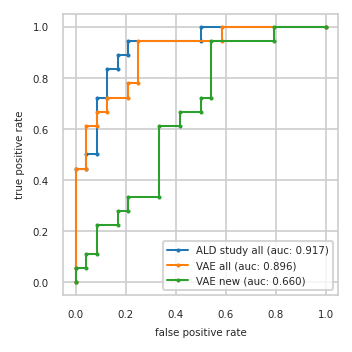

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.444   0.000 0.444   0.042 0.056
3          0.042 0.444   0.042 0.444   0.042 0.111
4          0.042 0.500   0.042 0.611   0.083 0.111
5          0.083 0.500   0.083 0.611   0.083 0.222
6          0.083 0.722   0.083 0.667   0.167 0.222
7          0.125 0.722   0.125 0.667   0.167 0.278
8          0.125 0.833   0.125 0.722   0.208 0.278
9          0.167 0.833   0.208 0.722   0.208 0.333
10         0.167 0.889   0.208 0.778   0.333 0.333
11         0.208 0.889   0.250 0.778   0.333 0.611
12         0.208 0.944   0.250 0.944   0.417 0.611
13         0.500 0.944   0.583 0.944   0.417 0.667
14         0.500 1.000   0.583 1.000   0.500 0.667
15         1.000 1.000   1.000 1.000   0.500 0.722
16           NaN   NaN     NaN   NaN   0.542 0.722
17           NaN   NaN     NaN   NaN   0.542 0.944
18           NaN   NaN     NaN   NaN   0.792 0.944
19           NaN   NaN     NaN   NaN   0.792 1.000
20           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,H3BLU2,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2,P51688
2,Q9NR34,A6NNI4;G8JLH6;P21926,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
3,P04075,Q9Y2T3;Q9Y2T3-3,P31321
4,P61981,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,P14174,P04075,Q96GD0
6,Q9Y2T3;Q9Y2T3-3,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P63104,Q14894,Q9NUQ9
8,C9JF17;P05090,A0A0C4DGY8;D6RA00;Q9UHY7,J3KSJ8;Q9UD71;Q9UD71-2


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


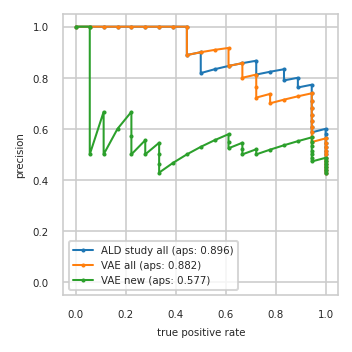

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.548 0.944     0.548 0.944
12         0.600 1.000     0.567 0.944     0.567 0.944
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.654 0.944     0.654 0.944     0.500 0.722
17         0.680 0.944     0.680 0.944     0.520 0.722
18         0.708 0.944     0.708 0.944     0.500 0.667
19         0.739 0.944     0.739 0.944     0.522 0.667
20         0.773 0.944     0.727 0.889     0.545 0.667
21         0.762 0.889     0.714 0.833     0.524 0.611
22         0.800 0.889     0.700 0.778     0.550 0.611
23         0.789 0.833     0.737 0.778     0.579 0.611
24         0.833 0.833     0.722 0.722     0.556 0.556
25         0.824 0.778     0.765 0.722     0.529 0.500
26         0.812 0.722     0.812 0.722     0.500 0.444
27         0.867 0.722     0.800 0.667     0.467 0.389
28         0.857 0.667     0.857 0.667     0.429 0.333
29         0.846 0.611     0.846 0.611     0.462 0.333
30         0.833 0.556     0.917 0.611     0.500 0.333
31         0.818 0.500     0.909 0.556     0.545 0.333
32         0.900 0.500     0.900 0.500     0.500 0.278
33         0.889 0.444     0.889 0.444     0.556 0.278
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


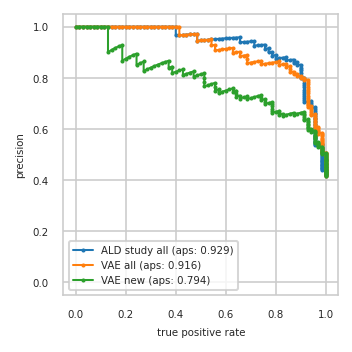

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


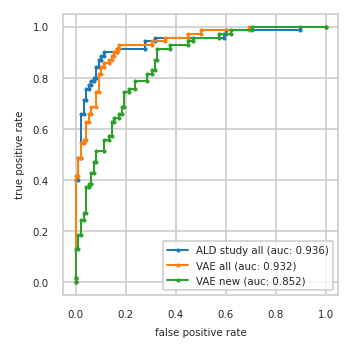

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}